In [77]:
# needed for GridSearch
import warnings
warnings.filterwarnings('ignore')
import timeit

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

path = Path('data', 'weatherAUS_clean.csv')
df = pd.read_csv(path)

In [46]:
# split into train and test
label = df.pop('RainTomorrow_Yes')
train_X, test_X, train_y, test_y = train_test_split(df, label, test_size= 0.3)

In [56]:
# Logistic Regression

# different values for most important hyper-parameters
parameter_space = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty': ['none', '11', '12', 'elasticnet'],
    'C': [0.001, 1, 1000],
}

clf = LogisticRegression()
clf = GridSearchCV(clf, parameter_space, n_jobs=-1, cv=5)
start = timeit.default_timer()
clf.fit(train_X, train_y)
stop = timeit.default_timer()

print('Runtime: %0.0f seconds' % (stop - start))
print('Best parameters found: ', clf.best_params_)
print('Mean-CV accuracy: %0.3f' % clf.best_score_)

predicitons = clf.predict(test_X)
print(metrics.classification_report(test_y, predicitons, digits=3))


Best parameters found:  {'C': 0.001, 'penalty': 'none', 'solver': 'newton-cg'}
Mean-CV accuracy: 0.853
              precision    recall  f1-score   support

           0      0.871     0.945     0.906     18177
           1      0.745     0.536     0.623      5472

    accuracy                          0.850     23649
   macro avg      0.808     0.740     0.765     23649
weighted avg      0.842     0.850     0.841     23649



In [54]:
# Decision Tree

parameter_space = {
    'criterion':['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': ['None', 5, 10, 20],
    'min_samples_split': [2, 3, 4],
    'max_leaf_nodes': ['None', 30, 50, 100],
}

clf = DecisionTreeClassifier()
clf = GridSearchCV(clf, parameter_space, n_jobs=-1, cv=5)
start = timeit.default_timer()
clf.fit(train_X, train_y)
stop = timeit.default_timer()

print('Runtime: %0.0f seconds' % (stop - start))
print('Best parameters found: ', clf.best_params_)
print('Mean-CV accuracy: %0.3f' % clf.best_score_)

predicitons = clf.predict(test_X)
print(metrics.classification_report(test_y, predicitons, digits=3))

Runtime: 88 seconds
Best parameters found:  {'criterion': 'entropy', 'max_depth': 10, 'max_leaf_nodes': 100, 'min_samples_split': 2, 'splitter': 'best'}
Mean-CV accuracy: 0.843
              precision    recall  f1-score   support

           0      0.863     0.938     0.899     18177
           1      0.710     0.505     0.590      5472

    accuracy                          0.838     23649
   macro avg      0.787     0.721     0.744     23649
weighted avg      0.828     0.838     0.827     23649



[Text(0.5, 0.875, 'X[11] <= 0.675\nentropy = 0.77\nsamples = 55179\nvalue = [42751, 12428]'),
 Text(0.25, 0.625, 'X[6] <= 0.645\nentropy = 0.56\nsamples = 43950\nvalue = [38203, 5747]'),
 Text(0.125, 0.375, 'X[7] <= 0.325\nentropy = 0.699\nsamples = 26336\nvalue = [21363, 4973]'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'X[13] <= 0.507\nentropy = 0.26\nsamples = 17614\nvalue = [16840, 774]'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'X[11] <= 0.815\nentropy = 0.974\nsamples = 11229\nvalue = [4548, 6681]'),
 Text(0.625, 0.375, 'X[7] <= 0.325\nentropy = 0.996\nsamples = 7056\nvalue = [3806, 3250]'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'X[13] <= 0.567\nentropy = 0.675\nsamples = 4173\nvalue = [742, 3431]'),
 Text(0.8125, 0.125, '\n  (...)  \n'),
 Text(0.9375, 0.125, '\n  (...)  \n')]

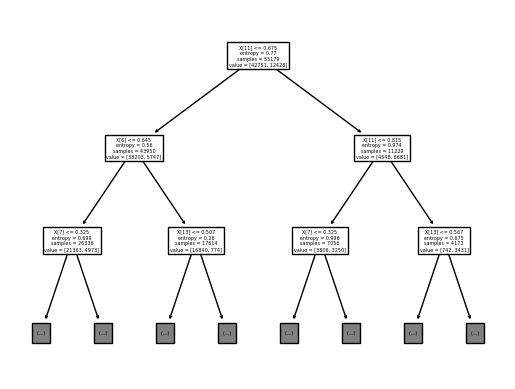

In [73]:
tree = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=10, max_leaf_nodes= 100, min_samples_split=2)
tree.fit(train_X, train_y)
#plt.figure(figsize=(50,50))
plot_tree(tree, max_depth=2)


In [85]:
# Bagged Tree

parameter_space = {
    'n_estimators' : [10, 50, 100, 200],
    'max_features' : [1, 0.5, 1.0, 10.0, 10],
}

clf = BaggingClassifier()
clf = GridSearchCV(clf, parameter_space, n_jobs=-1, cv=5)
start = timeit.default_timer()
clf.fit(train_X, train_y)
stop = timeit.default_timer()

print('Runtime: %0.0f seconds' % (stop - start))
print('Best parameters found: ', clf.best_params_)
print('Mean-CV accuracy: %0.3f' % clf.best_score_)

predicitons = clf.predict(test_X)
print(metrics.classification_report(test_y, predicitons, digits=3))

Runtime: 505 seconds
Best parameters found:  {'max_features': 1.0, 'n_estimators': 200}
Mean-CV accuracy: 0.861
              precision    recall  f1-score   support

           0      0.874     0.950     0.911     18177
           1      0.767     0.546     0.638      5472

    accuracy                          0.856     23649
   macro avg      0.820     0.748     0.774     23649
weighted avg      0.849     0.856     0.847     23649



In [84]:
# Random Forest

parameter_space = {
    'n_estimators' : [10, 50, 100, 200],
    'max_features' : ['sqrt', 'log2', None],
}

clf = RandomForestClassifier()
clf = GridSearchCV(clf, parameter_space, n_jobs=-1, cv=5)
start = timeit.default_timer()
clf.fit(train_X, train_y)
stop = timeit.default_timer()

print('Runtime: %0.0f seconds' % (stop - start))
print('Best parameters found: ', clf.best_params_)
print('Mean-CV accuracy: %0.3f' % clf.best_score_)

predicitons = clf.predict(test_X)
print(metrics.classification_report(test_y, predicitons, digits=3))

Runtime: 329 seconds
Best parameters found:  {'max_features': 'sqrt', 'n_estimators': 200}
Mean-CV accuracy: 0.861
              precision    recall  f1-score   support

           0      0.869     0.957     0.911     18177
           1      0.783     0.520     0.625      5472

    accuracy                          0.856     23649
   macro avg      0.826     0.738     0.768     23649
weighted avg      0.849     0.856     0.845     23649

